# Librerías

In [1]:
# Cargar paquetes
import numpy as np      
import pandas as pd     
import matplotlib.pyplot as plt 

import tensorflow as tf
import keras 
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Matriz de confusion
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

/Users/juan/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:34: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


# Funciones

In [2]:
def get_column_names():

    # Definir los nombres de las columnas según la documentación
    column_names = [
        'Elevation', 'Aspect', 'Slope',
        'Horizontal_Distance_To_Hydrology', 'Vertical_Distance_To_Hydrology',
        'Horizontal_Distance_To_Roadways', 'Hillshade_9am', 'Hillshade_Noon',
        'Hillshade_3pm', 'Horizontal_Distance_To_Fire_Points'
    ]

    # Agregar columnas para Wilderness_Area (4 columnas binarias)
    wilderness_areas = [f'Wilderness_Area_{i}' for i in range(1, 5)]
    column_names.extend(wilderness_areas)

    # Agregar columnas para Soil_Type (40 columnas binarias)
    soil_types = [f'Soil_Type_{i}' for i in range(1, 41)]
    column_names.extend(soil_types)

    # Agregar la columna objetivo 'Cover_Type'
    column_names.append('Cover_Type')

    return column_names


def download_and_save_csv(p=0.50,seed=42,csv_file="covertype_sample.csv"):

    # Obtener los nombres de las columnas
    column_names = get_column_names()

    # URL del dataset
    url = "https://archive.ics.uci.edu/ml/machine-learning-databases/covtype/covtype.data.gz"

    # Cargar los datos desde la URL con los nombres de las columnas
    df = pd.read_csv(url, header=None, names=column_names)

    # Tomar el 50% de los datos de manera aleatoria
    df_sample = df.sample(frac=p, random_state=seed)

    # Guardar en local para no volver a ejecutar la extracción
    df_sample.to_csv(csv_file, index=False)

def train_and_test_preparation(df, target_column="Cover_Type", test_size=0.2, random_state=42, num_classes=7, one_hot_encoding=True):
    # Separar características y etiquetas
    X = df.drop(columns=[target_column])
    y = df[target_column] - 1

    # Normalizar los datos
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    # Dividir en conjunto de entrenamiento y prueba
    X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=test_size, random_state=random_state)
    print(f"X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")
    print(f"X_test shape: {X_test.shape}, y_test shape: {y_test.shape}")

    if one_hot_encoding:
        # y_test y y_train debe estar en formato one-hot
        y_test = keras.utils.to_categorical(y_test, num_classes=num_classes)
        y_train = keras.utils.to_categorical(y_train, num_classes=num_classes)

    return X_train, X_test, y_train, y_test

def basic_model(X_train, num_classes=7, activation='softmax', optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy']):
    model = tf.keras.models.Sequential([
    tf.keras.Input(shape=(X_train.shape[1],)),  # Definir la entrada explícitamente
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(num_classes, activation=activation)  # 7 clases en la variable objetivo
    ])


    print(model.summary())

    model.compile(optimizer=optimizer, # otros optimizadores para clasificación: sgd, rmsprop, adagrad, adadelta, adamax, nadam
              loss=loss, 
              metrics=metrics)
    
    return model

def train_and_evaluation_model(model, X_train, y_train, X_test, y_test, epochs=15, batch_size=128, validation_split=0.2):
    # Entrenamiento del modelo
    history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_split=validation_split)

    # Evaluación del modelo
    loss, accuracy = model.evaluate(X_test, y_test)
    print(f"Precisión en test: {accuracy:.4f}")

    # Visualizmos el resultado
    print(history.history.keys())
    history = pd.DataFrame(history.history)
    print(history)
    history.plot()

    # Representamos por separado la evolucion de la funcion de perdida y el accuracy
    dfAccuracy = history.loc[:,["accuracy","val_accuracy"]]
    dfAccuracy.plot()

    dfLoss = history.loc[:,["loss","val_loss"]]
    dfLoss.plot()

    return history, dfAccuracy, dfLoss

def accuracy_by_classs(conf_matrix):
    """
    Calcula el accuracy por clase a partir de una matriz de confusión.
    """
    class_acc = {}
    
    for i in range(len(conf_matrix)):  # Para cada clase
        TP = conf_matrix[i, i]  # Verdaderos positivos (diagonal)
        total_real = np.sum(conf_matrix[i, :])  # Total de ejemplos de esa clase (suma de la fila)
        
        accuracy = TP / total_real if total_real != 0 else 0  # Evitar división por 0
        class_acc[f"Clase {i}"] = accuracy
    
    return class_acc

def prediction_and_confusion_matrix(model, X_test, y_test):
    # Lo hacemos para todo el conjunto de test
    predicciones = model.predict(X_test)

    # Obtenemos la categoria donde se produce el maximo de la probabilidad de clasificacion
    predic_test = np.argmax(predicciones, axis=1)
    originales_test = np.argmax(y_test, axis=1) 

    # Matriz de contingencia o matriz de confusion
    conf_matrix = confusion_matrix(originales_test, predic_test)
    
    # Print de la matriz de confusion
    class_names = ['0','1','2','3','4','5','6']
    disp = ConfusionMatrixDisplay(confusion_matrix = conf_matrix, display_labels = class_names)
    disp = disp.plot(cmap=plt.cm.Blues,values_format='g')

    # Accuracy por clase
    accuracy_per_class = accuracy_by_classs(conf_matrix)

    # Mostrar resultados
    for clase, acc in accuracy_per_class.items():
        print(f"{clase}: {acc:.2%}")


# Lectura de datos

In [3]:
# Descargar y guardar el archivo (descomentar para ejecutar)
download_and_save_csv()

# Cargar el archivo
df = pd.read_csv("covertype_sample.csv")

# Tamaño del dataset
# 581k datapoints y 55 variables
print(df.shape)

# Identificamos valores perdidos en el dataset pero no hay ninguno
df.isna().sum()

# Describe el dataset
print(df.describe())

# ¿Cuánto de balanceadas estñan las clases?
# La clase 2 es la más común
print(df["Cover_Type"].value_counts())

(290506, 55)
           Elevation         Aspect          Slope  \
count  290506.000000  290506.000000  290506.000000   
mean     2959.158720     155.632878      14.103488   
std       279.859278     111.802536       7.489588   
min      1863.000000       0.000000       0.000000   
25%      2808.000000      59.000000       9.000000   
50%      2995.000000     127.000000      13.000000   
75%      3163.000000     260.000000      18.000000   
max      3858.000000     360.000000      65.000000   

       Horizontal_Distance_To_Hydrology  Vertical_Distance_To_Hydrology  \
count                     290506.000000                   290506.000000   
mean                         268.986190                       46.362044   
std                          212.443586                       58.195488   
min                            0.000000                     -173.000000   
25%                          108.000000                        7.000000   
50%                          218.000000           

# RRNN - Primer modelo

## Modelo 

X_train shape: (232404, 54), y_train shape: (232404,)
X_test shape: (58102, 54), y_test shape: (58102,)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 64)             │         3,520 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 7)              │           231 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,831 (22.78 KB)

 Trainable params: 5,831 (22.78 KB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/30
1453/1453 ━━━━━━━━━━━━━━━━━━━━ 2s 947us/step - accuracy: 0.6756 - loss: 0.8186 - val_accuracy: 0.7542 - val_loss: 0.5729
Epoch 2/30
1453/1453 ━━━━━━━━━━━━━━━━━━━━ 1s 767us/step - accuracy: 0.7593 - loss: 0.5589 - val_accuracy: 0.7709 - val_loss: 0.5308
Epoch 3/30
1453/1453 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.7749 - loss: 0.5223 - val_accuracy: 0.7854 - val_loss: 0.5012
Epoch 4/30
1453/1453 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.7859 - loss: 0.4976 - val_accuracy: 0.7924 - val_loss: 0.4883
Epoch 5/30
1453/1453 ━━━━━━━━━━━━━━━━━━━━ 1s 976us/step - accuracy: 0.7955 - loss: 0.4807 - val_accuracy: 0.7981 - val_loss: 0.4750
Epoch 6/30
1453/1453 ━━━━━━━━━━━━━━━━━━━━ 1s 940us/step - accuracy: 0.8019 - loss: 0.4656 - val_accuracy: 0.8017 - val_loss: 0.4634
Epoch 7/30
1453/1453 ━━━━━━━━━━━━━━━━━━━━ 1s 815us/step - accuracy: 0.8076 - loss: 0.4526 - val_accuracy: 0.8096 - val_loss: 0.4509
Epoch 8/30
1453/1453 ━━━━━━━━━━━━━━━━━━━━ 1s 767us/step - accuracy: 0.8121 

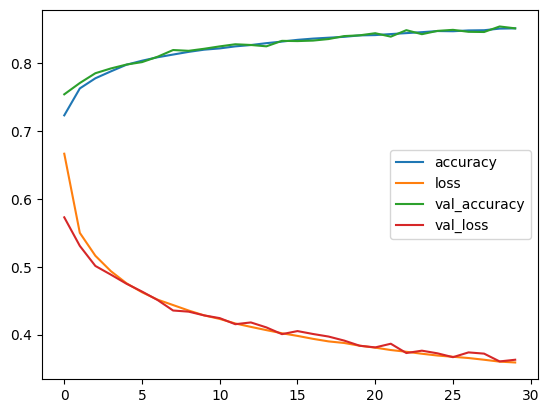

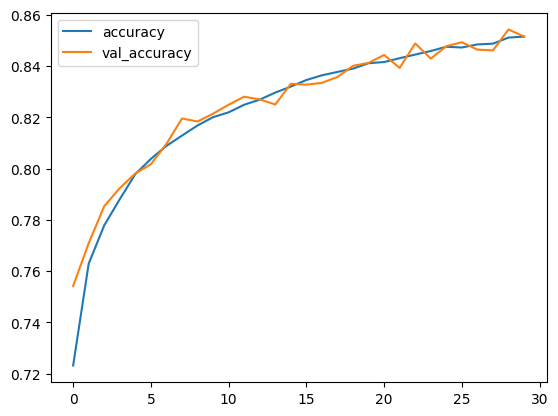

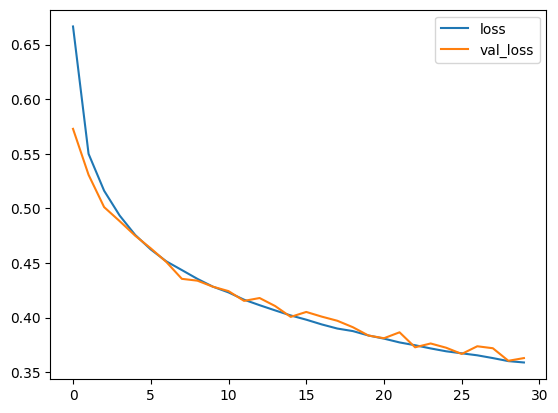

In [4]:
# Train and test preparation
X_train, X_test, y_train, y_test = train_and_test_preparation(df)

# Modelo básico
model = basic_model(X_train)

# Entrenar el modelo
history = train_and_evaluation_model(model, X_train, y_train, X_test, y_test, epochs=30)

# save
model.save('GavaldaNataliainicial.keras')

## Predicciones y matriz de confusion

1816/1816 ━━━━━━━━━━━━━━━━━━━━ 1s 308us/step
Clase 0: 85.69%
Clase 1: 88.03%
Clase 2: 86.24%
Clase 3: 66.79%
Clase 4: 44.94%
Clase 5: 59.69%
Clase 6: 78.64%


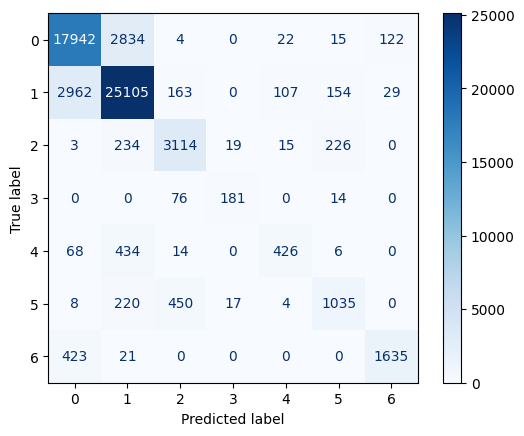

In [5]:
prediction_and_confusion_matrix(model, X_test, y_test)

## Conclusiones
- El dataset utilizado supone el 50% de la fuente de datos original. Disponemos de 54 variables y 232.404 data points.
- El modelo predice en términos globales pero observamos que falla más en las clases 3, 4, 5
- La muestra se encuentra desbalanceada y con menos registros en las clases que falla más.
- No se comete sobreentrenamiento con 15 épocas del entrenamiento

# RRNN - Añadir dato sintético
Añadimos más ejemplos sintéticos en la clase 4. En el momento que los tengamos, aplicaremos el mismo modelo a los datos para ver si mejoran las predicciones en esta clase y puede valorarse esta estrategia.

### Preparacion de datos

In [6]:
# Dimension original de los datos
print("Tamaño del df original (filas x columnas)", df.shape)

# Remuestreamos con reemplazamiento sobre las categorias 4 y 5
filtro_4 = df['Cover_Type'] == 4 

# Valores originales
print("Originales del tipo Cover_Type 4: ", sum(filtro_4))

# Remuestreo
nuevos_4 = df[filtro_4].sample(n=2000, replace=True)

# Datos ampliados
df_ampliado = pd.concat([df, nuevos_4])
print("Tamaño del df ampliado (filas x columnas)", df_ampliado.shape)

Tamaño del df original (filas x columnas) (290506, 55)
Originales del tipo Cover_Type 4:  1352
Tamaño del df ampliado (filas x columnas) (292506, 55)


### Modelo

X_train shape: (234004, 54), y_train shape: (234004,)
X_test shape: (58502, 54), y_test shape: (58502,)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_3 (Dense)                 │ (None, 64)             │         3,520 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 7)              │           231 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,831 (22.78 KB)

 Trainable params: 5,831 (22.78 KB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/30
1463/1463 ━━━━━━━━━━━━━━━━━━━━ 2s 961us/step - accuracy: 0.6801 - loss: 0.8073 - val_accuracy: 0.7512 - val_loss: 0.5818
Epoch 2/30
1463/1463 ━━━━━━━━━━━━━━━━━━━━ 1s 816us/step - accuracy: 0.7551 - loss: 0.5688 - val_accuracy: 0.7683 - val_loss: 0.5408
Epoch 3/30
1463/1463 ━━━━━━━━━━━━━━━━━━━━ 1s 894us/step - accuracy: 0.7726 - loss: 0.5284 - val_accuracy: 0.7796 - val_loss: 0.5124
Epoch 4/30
1463/1463 ━━━━━━━━━━━━━━━━━━━━ 1s 872us/step - accuracy: 0.7857 - loss: 0.5022 - val_accuracy: 0.7907 - val_loss: 0.4901
Epoch 5/30
1463/1463 ━━━━━━━━━━━━━━━━━━━━ 1s 847us/step - accuracy: 0.7925 - loss: 0.4848 - val_accuracy: 0.7996 - val_loss: 0.4736
Epoch 6/30
1463/1463 ━━━━━━━━━━━━━━━━━━━━ 1s 869us/step - accuracy: 0.7999 - loss: 0.4689 - val_accuracy: 0.8039 - val_loss: 0.4646
Epoch 7/30
1463/1463 ━━━━━━━━━━━━━━━━━━━━ 1s 935us/step - accuracy: 0.8076 - loss: 0.4565 - val_accuracy: 0.8106 - val_loss: 0.4530
Epoch 8/30
1463/1463 ━━━━━━━━━━━━━━━━━━━━ 1s 854us/step - accuracy: 0.8

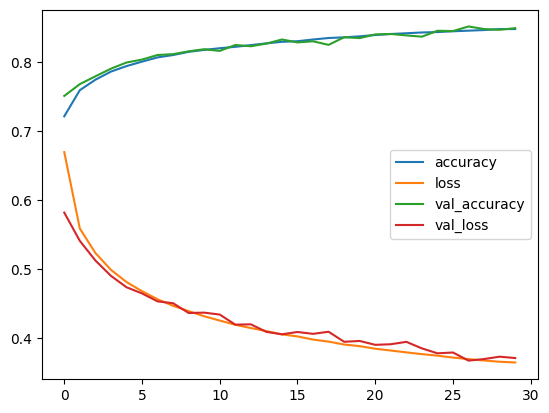

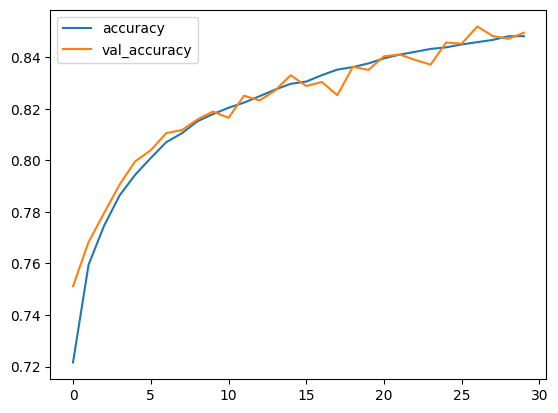

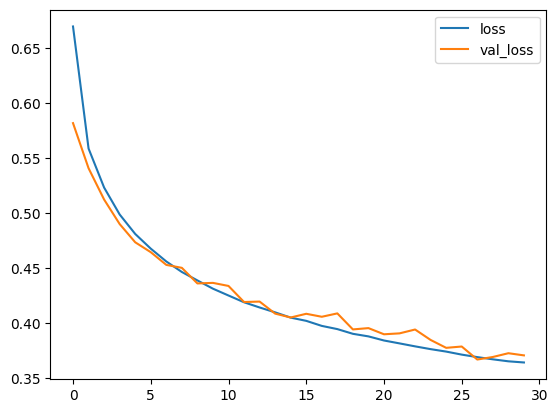

In [7]:
# Train and test preparation
X_train, X_test, y_train, y_test = train_and_test_preparation(df_ampliado)

# Modelo básico
model = basic_model(X_train)

# Entrenar el modelo
history = train_and_evaluation_model(model, X_train, y_train, X_test, y_test, epochs=30)

### Predicciones, matriz de confusión y conclusiones

1829/1829 ━━━━━━━━━━━━━━━━━━━━ 1s 348us/step
Clase 0: 82.52%
Clase 1: 89.98%
Clase 2: 75.38%
Clase 3: 83.15%
Clase 4: 39.72%
Clase 5: 75.84%
Clase 6: 81.51%


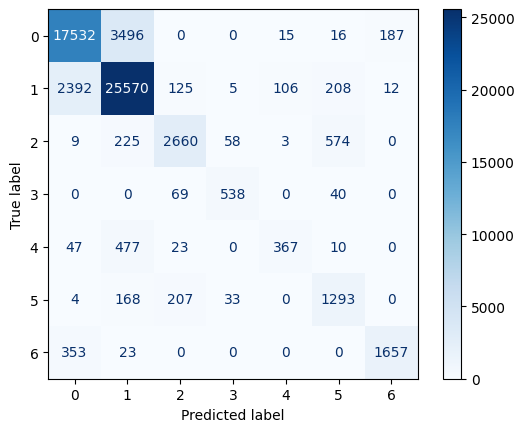

In [8]:
prediction_and_confusion_matrix(model, X_test, y_test)

### Conclusiones
- Hay una mejoría en las clasificación de determinadas clases. 

Primer modelo: Accuracy 0.85
- Clase 0: 84.98%
- Clase 1: 87.45%
- Clase 2: 89.23%
- Clase 3: 76.01%
- Clase 4: 45.57%
- Clase 5: 64.13%
- Clase 6: 80.04%

Modelo actual: Accuracy 0.84
- Clase 0: 85.61%
- Clase 1: 85.98%
- Clase 2: 85.83%
- Clase 3: 83.00%
- Clase 4: 47.84%
- Clase 5: 68.68%
- Clase 6: 80.13%

Las clases que menos representación tienen en la muestra han mejorado, es decir, el modelo con dato sintético para la clase 4 ha mejorado las predicciones para la clase 4 además de para la clase 3 y 5. Entonces, continuaremos trabajando con el conjunto de datos ampliado. 

Adicionalmente, viendo los valores de la matriz de confusión que no están en la diagonal, el modelo puede no estar clasificando correctamente debido a que algunas de las clases pueden ser similares y entonces el modelo las "confund. Puede ser el caso de la clase 4 con clase 1, el caso de la clase 5 con la 2 o el de la clase 6 con la clase 0.

Entonces, como resumen podrían estar ocurriendo dos escenarios (simultaneamente o no) por lo que no incrementamos el accuracy:
- Las clases se encuentran desbalanceadas y el modelo no consigue aprender correctamente las clases que son minoritarias.
- Hay determinadas clases que pueden ser muy similares en características y el modelo no sea capaz de aprender a clasificarlas totalmente bien.

# RRNN - Validación cruzada

In [9]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Función de validación cruzada con matriz de confusión por pliegue
def cross_validation_training(df, k=5, num_classes=7, batch_size=32, epochs=20):
    """
    Aplica validación cruzada con k-fold en un problema de clasificación multiclase usando Keras y muestra la matriz de confusión por cada pliegue.
    
    Parámetros:
    - df: DataFrame con los datos.
    - k: Número de pliegues para validación cruzada (default=5).
    - num_classes: Número de clases en la variable objetivo.
    - batch_size: Tamaño del lote para el entrenamiento.
    - epochs: Número de épocas de entrenamiento por pliegue.
    """
    
    # Preparar los datos
    X_train, X_test, y_train, y_test = train_and_test_preparation(df, one_hot_encoding=False)  # Sin one-hot encoding aún

    # Asegurar que y_train tenga valores enteros de 0 a 6
    y_train_labels = np.array(y_train).astype(int)  # Necesario para StratifiedKFold

    # Configuración de Stratified K-Fold
    kfold = StratifiedKFold(n_splits=k, shuffle=True, random_state=123)

    # Almacenar métricas y matrices de confusión
    accuracy_scores = []
    loss_scores = []
    conf_matrices = []

    for fold, (train_idx, val_idx) in enumerate(kfold.split(X_train, y_train_labels)):  # Usamos etiquetas enteras aquí
        
        # División de datos en entrenamiento y validación
        X_train_fold, X_val_fold = X_train[train_idx], X_train[val_idx]
        y_train_fold, y_val_fold = y_train_labels[train_idx], y_train_labels[val_idx]

        # Convertir etiquetas a one-hot encoding para entrenamiento del modelo
        y_train_fold_one_hot = keras.utils.to_categorical(y_train_fold, num_classes=num_classes)
        y_val_fold_one_hot = keras.utils.to_categorical(y_val_fold, num_classes=num_classes)

        # Crear el modelo para cada pliegue
        model = basic_model(X_train_fold, num_classes=num_classes)

        # Entrenar el modelo en el pliegue actual
        history = model.fit(X_train_fold, y_train_fold_one_hot, 
                            epochs=epochs, 
                            batch_size=batch_size, 
                            verbose=0,
                            validation_data=(X_val_fold, y_val_fold_one_hot))  

        # Evaluar el modelo en el conjunto de validación
        val_loss, val_acc = model.evaluate(X_val_fold, y_val_fold_one_hot, verbose=0)

        # Guardar métricas
        accuracy_scores.append(val_acc)
        loss_scores.append(val_loss)

        # Obtener predicciones en el conjunto de validación
        y_pred_one_hot = model.predict(X_val_fold)
        y_pred_labels = np.argmax(y_pred_one_hot, axis=1)  # Convertir de one-hot a etiquetas

        # Calcular y guardar la matriz de confusión
        conf_matrix = confusion_matrix(y_val_fold, y_pred_labels)
        conf_matrices.append(conf_matrix)

    # Calcular métricas finales
    final_accuracy = np.mean(accuracy_scores)
    sd_accuracy = np.std(accuracy_scores)
    final_loss = np.mean(loss_scores)
    sd_loss = np.std(loss_scores)

    # Mostrar resultados finales de la validación cruzada
    print("\n📌 Resultados de Validación Cruzada")
    print("Loss validación cruzada: ", np.round(final_loss, 2), " Desviación típica: ", np.round(sd_loss, 4))
    print("Accuracy validación cruzada: ", np.round(final_accuracy, 2), " Desviación típica: ", np.round(sd_accuracy, 4))

    # Visualizar todas las matrices de confusión en subgráficos
    fig, axes = plt.subplots(1, k, figsize=(20, 5))
    for i, conf_matrix in enumerate(conf_matrices):
        sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", ax=axes[i])
        axes[i].set_title(f"Fold {i+1}")
        axes[i].set_xlabel("Predicción")
        axes[i].set_ylabel("Clase Real")

    plt.tight_layout()
    plt.show()

    return final_accuracy, final_loss, conf_matrices


X_train shape: (234004, 54), y_train shape: (234004,)
X_test shape: (58502, 54), y_test shape: (58502,)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_6 (Dense)                 │ (None, 64)             │         3,520 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 7)              │           231 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,831 (22.78 KB)

 Trainable params: 5,831 (22.78 KB)

 Non-trainable params: 0 (0.00 B)

None
1463/1463 ━━━━━━━━━━━━━━━━━━━━ 1s 326us/step


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_9 (Dense)                 │ (None, 64)             │         3,520 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 7)              │           231 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,831 (22.78 KB)

 Trainable params: 5,831 (22.78 KB)

 Non-trainable params: 0 (0.00 B)

None
1463/1463 ━━━━━━━━━━━━━━━━━━━━ 0s 279us/step


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_12 (Dense)                │ (None, 64)             │         3,520 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 7)              │           231 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,831 (22.78 KB)

 Trainable params: 5,831 (22.78 KB)

 Non-trainable params: 0 (0.00 B)

None
1463/1463 ━━━━━━━━━━━━━━━━━━━━ 1s 378us/step


Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_15 (Dense)                │ (None, 64)             │         3,520 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ (None, 7)              │           231 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,831 (22.78 KB)

 Trainable params: 5,831 (22.78 KB)

 Non-trainable params: 0 (0.00 B)

None
1463/1463 ━━━━━━━━━━━━━━━━━━━━ 1s 587us/step


Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_18 (Dense)                │ (None, 64)             │         3,520 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_19 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_20 (Dense)                │ (None, 7)              │           231 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,831 (22.78 KB)

 Trainable params: 5,831 (22.78 KB)

 Non-trainable params: 0 (0.00 B)

None
1463/1463 ━━━━━━━━━━━━━━━━━━━━ 0s 309us/step

📌 Resultados de Validación Cruzada
Loss validación cruzada:  0.38  Desviación típica:  0.0151
Accuracy validación cruzada:  0.85  Desviación típica:  0.0031


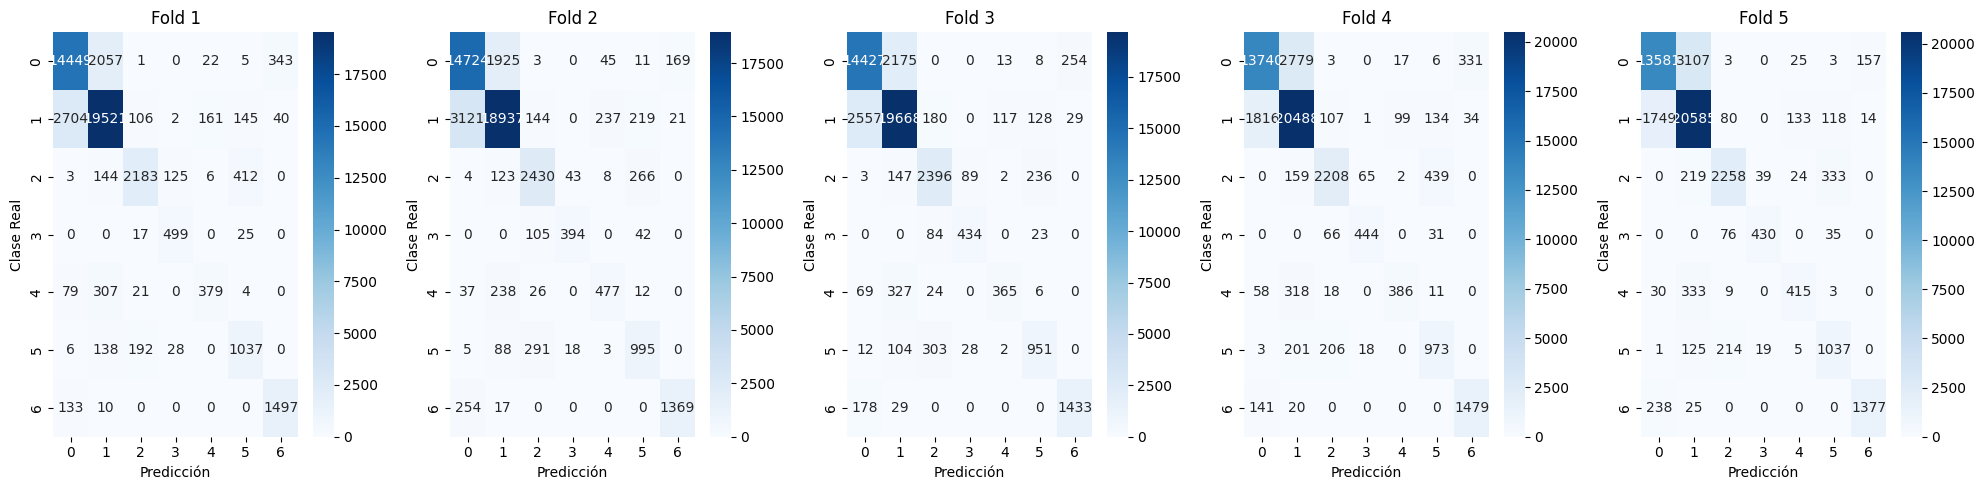

(0.8459940910339355,
 0.38022775650024415,
 [array([[14449,  2057,     1,     0,    22,     5,   343],
         [ 2704, 19521,   106,     2,   161,   145,    40],
         [    3,   144,  2183,   125,     6,   412,     0],
         [    0,     0,    17,   499,     0,    25,     0],
         [   79,   307,    21,     0,   379,     4,     0],
         [    6,   138,   192,    28,     0,  1037,     0],
         [  133,    10,     0,     0,     0,     0,  1497]]),
  array([[14724,  1925,     3,     0,    45,    11,   169],
         [ 3121, 18937,   144,     0,   237,   219,    21],
         [    4,   123,  2430,    43,     8,   266,     0],
         [    0,     0,   105,   394,     0,    42,     0],
         [   37,   238,    26,     0,   477,    12,     0],
         [    5,    88,   291,    18,     3,   995,     0],
         [  254,    17,     0,     0,     0,     0,  1369]]),
  array([[14427,  2175,     0,     0,    13,     8,   254],
         [ 2557, 19668,   180,     0,   117,   128,  

In [10]:
cross_validation_training(df_ampliado, k=5, epochs=20, batch_size=32)

## Conclusiones

Ahora, junto con el dato ampliado y la versión del modelo más sencilla trabajada en el primer escenario, hemos aplicado validación cruzada. Vemos que no mejoramos en términos generales nuestra predicción, el accuracy se mantiene en 0.85 igual que en el segundo modelo propuesto con dato ampliado. 

Una de las mejoras que hemos visto ha sido en la predicción de la clase 6, aquí la predicción ha mejorado puesto que ha decrementado el número de observaciones que son de clase 6 pero se han predicho como clase 0. También se ha visto que ha mejorado ligeramente las predicciones de la clase 5 y 5 de la misma manera.

# RRNN - Dropout

# RNNN - Early Stoping